In [1]:
import sys, os

# Add parent directory to Python path to import custom modules
sys.path.append(os.path.abspath(".."))

# Import our custom data processing class
from src.data_processor import DataProcessor

## 2A. Data Cleaning

The Africa-wide dataset used in this assignment was derived from the UN DESA population and health indicators. Data cleaning focused on ensuring completeness, correctness, and internal consistency before moving to supervised modeling.

### Handling Missing Values

Only one variable contained missing data:

- `maternal_mortality_ratio_deaths_per_100000_population`, with roughly 25% missing values, all from the year 2024. A verification against the original long-format UN dataset confirmed that these entries were not reported at all for this year. This establishes a pattern of **systematic non-reporting**, not random missingness or cleaning errors.

Because these missing values reflect genuine absence of data, we:

- Did not impute maternal mortality values.
- Did not drop the corresponding rows.
- Restricted models involving maternal mortality to the years with complete data.

All other indicators (fertility, under-five mortality, life expectancy, population growth) had no missing values, so no imputation was necessary.

### Addressing Outliers

The dataset contains real demographic extremes such as:

- Very high fertility rates (≥7)
- Elevated under-five mortality (>150 per 1,000)
- High maternal mortality (>1,000 per 100,000)

These values originate from countries with documented health challenges and are **true characteristics** of African demographic variation, not anomalies. Therefore, we adopted a retention-based strategy:

- Outliers were left unchanged.
- No capping, clipping, or transformations were applied.

This ensures fidelity to real-world population health patterns and avoids masking meaningful disparities across the continent.

### Ensuring Data Quality and Consistency

To guarantee dataset integrity:

- All numeric columns were cast to appropriate numeric types.
- Region and country names were standardized by trimming whitespace.
- Column names were normalized to lowercase with underscores for modeling compatibility.
- Dataset structure was validated to ensure **one unique record per country–year pair**.

After these checks, the dataset was confirmed clean, consistent, and ready for feature engineering.


In [2]:
# Initialize the DataProcessor with the path to our raw dataset
processor = DataProcessor(r"../df_africa_cleaned.xls")
df_clean = processor.process()


# Process the raw data through cleaning pipeline
df_clean = processor.process()

# Display first 5 rows to verify successful data loading and cleaning
df_clean.head()



,code,region_country_area,year,life_expectancy_at_birth_for_both_sexes_years,life_expectancy_at_birth_for_females_years,life_expectancy_at_birth_for_males_years,maternal_mortality_ratio_deaths_per_100000_population,population_annual_rate_of_increase_percent,total_fertility_rate_children_per_women,under_five_mortality_rate_for_both_sexes_per_1000_live_births
0,2,Africa,2010,58.8,60.3,57.2,593.0,2.6,4.9,93.9
1,2,Africa,2015,60.8,62.6,59.1,526.0,2.6,4.6,81.0
2,2,Africa,2020,62.3,64.3,60.2,487.0,2.4,4.2,69.0
3,2,Africa,2024,64.0,66.1,62.0,NaN,2.3,4.0,62.4
4,11,Western Africa,2010,54.3,55.1,53.5,850.0,2.8,5.7,123.2


#### output explanation:
DATA COLLECTION: This dataset originates from UN 
 
 COLUMN MEANINGS:
- country: African nation name (54 countries total)
- year: Time period (2010-2024, annual observations)
- region: UN geographic sub-region classification (Eastern, Western, Northern, etc.)
 - total_fertility_rate: Average children per woman during reproductive years
 - life_expectancy_at_birth_for_both_sexes_years: Expected lifespan at birth (combined gender)
 - under_five_mortality_rate_deaths_per_1000_live_births: Child deaths before age 5 per 1,000 births
 - maternal_mortality_ratio_deaths_per_100000_population: Maternal deaths per 100,000 live births
 - population_annual_rate_of_increase_percent: Year-over-year population growth rate

PREPROCESSING DECISIONS:
 - Column names standardized to lowercase with underscores for Python compatibility
 - Numeric columns cast to float64 for mathematical operations
 - Country/region names trimmed of whitespace for consistency
 - Missing values in maternal mortality preserved (systematic non-reporting for 2024)
 - No outlier removal to preserve genuine demographic variation across Africa

 STATISTICAL MEANING:
 - Each row represents one country-year observation (panel data structure)
 - Values reflect official government statistics and UN demographic estimates
 - Fertility rates >4 indicate countries in early demographic transition
 - Life expectancy ranges from ~50-80 years across African nations
 - Under-5 mortality varies dramatically (5-150 per 1,000) reflecting health system quality

## 2B. Feature Engineering

Feature engineering was applied to enrich the dataset with additional information that improves predictive performance and provides deeper analytical insight into demographic transitions across African countries. All engineered features were derived from domain knowledge, prior EDA findings, and the goals of the hypotheses being tested.

### Trend Features (2010–2024)

To capture the *direction and magnitude* of demographic change over time, we computed trend-based features representing the difference between each country’s earliest and latest available values:

\[
Change_2010–2024 = Value_2024 - Value_2010
\]

Trend features were generated for four core indicators:

- Life expectancy (both sexes)
- Total fertility rate
- Under-five mortality rate
- Population growth rate

These engineered features quantify how far each country has progressed over the study period and allow the models to learn *trajectories*, not just static snapshots. They are especially relevant given Africa’s ongoing demographic transition.

### Country-Level Mean Indicator Features

Short-term fluctuations in demographic indicators can obscure broader patterns. To incorporate structural characteristics of each country, we generated mean-level aggregates across all available years (2010–2024):

- Mean life expectancy (both sexes)
- Mean total fertility rate
- Mean under-five mortality rate
- Mean population growth rate

These averaged features provide stable representations of each country’s demographic profile and improve model robustness by reducing year-to-year noise.

### Scaling (Performed in the Modeling Pipeline)

Certain machine learning algorithms—particularly linear models—are sensitive to differences in feature scale. To address this, numeric features were standardized *after* the train-test split to prevent data leakage:

- Standard scaling (`z = (x - μ) / σ`) was applied only inside the modeling pipeline.
- The raw dataset remains unscaled to maintain interpretability.

### Summary

In total, **eight engineered features** were created:

- **4 trend features** capturing demographic progress over time  
- **4 mean features** summarizing long-term national characteristics  

These additions strengthen model performance by incorporating both temporal dynamics and structural demographic patterns. The resulting feature set provides a richer foundation for regression-based predictive modeling and directly supports the assignment’s analytical objectives.


### Testing the Feature Engineering logic

In [3]:
from src.data_processor import DataProcessor
from src.feature_engineer import FeatureEngineer



# Initialize the FeatureEngineer with our cleaned dataset
fe = FeatureEngineer(df_clean)
# Process the cleaned data through feature engineering pipeline
df_features = fe.process()

# Display first 5 rows to verify feature engineering success
df_features.head()


,code,region_country_area,year,life_expectancy_at_birth_for_both_sexes_years,life_expectancy_at_birth_for_females_years,life_expectancy_at_birth_for_males_years,maternal_mortality_ratio_deaths_per_100000_population,population_annual_rate_of_increase_percent,total_fertility_rate_children_per_women,under_five_mortality_rate_for_both_sexes_per_1000_live_births,life_expectancy_at_birth_for_both_sexes_years_change_2010_2024,total_fertility_rate_children_per_women_change_2010_2024,under_five_mortality_rate_for_both_sexes_per_1000_live_births_change_2010_2024,population_annual_rate_of_increase_percent_change_2010_2024,life_expectancy_at_birth_for_both_sexes_years_mean,total_fertility_rate_children_per_women_mean,under_five_mortality_rate_for_both_sexes_per_1000_live_births_mean,population_annual_rate_of_increase_percent_mean
0,2,Africa,2010,58.8,60.3,57.2,593.0,2.6,4.9,93.9,5.2,-0.9,-31.5,-0.3,61.475,4.425,76.575,2.475
1,2,Africa,2015,60.8,62.6,59.1,526.0,2.6,4.6,81.0,5.2,-0.9,-31.5,-0.3,61.475,4.425,76.575,2.475
2,2,Africa,2020,62.3,64.3,60.2,487.0,2.4,4.2,69.0,5.2,-0.9,-31.5,-0.3,61.475,4.425,76.575,2.475
3,2,Africa,2024,64.0,66.1,62.0,NaN,2.3,4.0,62.4,5.2,-0.9,-31.5,-0.3,61.475,4.425,76.575,2.475
4,11,Western Africa,2010,54.3,55.1,53.5,850.0,2.8,5.7,123.2,4.1,-1.3,-34.0,-0.6,56.300,5.000,105.275,2.475


#### OutPut Explanation

 TEMPORAL TREND FEATURES (Change from 2010 to 2024):
 - life_expectancy_change_2010_2024: Health system improvement over 14 years
 - total_fertility_rate_change_2010_2024: Reproductive behavior shifts
 - under_five_mortality_change_2010_2024: Child health progress indicator
 - population_growth_change_2010_2024: Demographic momentum changes

 STATISTICAL MEANING OF TREND FEATURES:
 - Positive values = improvement/increase over time period
 - Negative fertility/mortality changes = demographic progress
- Negative population growth changes = demographic transition toward stability

AGGREGATED FEATURES (Country-level means across 2010-2024):
- mean_life_expectancy_both_sexes: Long-term health outcome baseline
- mean_total_fertility_rate: Average reproductive pattern per country
- mean_under_five_mortality: Persistent child health challenges
- mean_population_annual_rate_increase: Characteristic growth pattern

FEATURE ENGINEERING RATIONALE:
- Trends capture demographic transition dynamics over time
- Means smooth annual fluctuations for stable model inputs

### Understanding the Engineered Feature Output

Some engineered features appear the same across all years for a given country or region. This is expected and correct.

**Why?**

1. **Trend Features (2010–2024 Change)**  
   These measure how much an indicator changed from 2010 to 2024.  
   Since the change is calculated *once per country*, the value stays the same in all rows for that country.

2. **Mean Features (2010–2024 Average)**  
   These represent the long-term average level of each indicator.  
   A mean is also *constant per country*, so it repeats for all years.

**What varies?**  
The original demographic indicators (life expectancy, fertility, mortality, growth) still vary year-by-year, which provides the temporal dynamics needed for modeling.

**Why this is useful?**  
The model now has both:  
- year-specific values (dynamic changes)  
- country-level characteristics (structural patterns)

This combination strengthens predictive performance and aligns with standard demographic modeling practice.


# Model Testing

## H1: Fertility predicts maternal mortality (REGRESSION)

In [4]:
from src.model_trainer import ModelTrainer


In [5]:
# H1: Fertility predicts maternal mortality (REGRESSION)

# Initialize trainer for maternal mortality regression
trainer_h1 = ModelTrainer(
    df_features,
    target="maternal_mortality_ratio_deaths_per_100000_population",
    problem_type="regression"
)

# Split data into training and testing sets (stratified for consistency)
trainer_h1.train_test_split()
trainer_h1.train_test_split()
trainer_h1.scale_numeric()

# Train multiple regression models and select the best performer
best_h1, params_h1 = trainer_h1.train_models()

# Generate predictions and compile results with actual vs predicted values
results_h1 = trainer_h1.map_predictions()
results_h1.head()



Train/Test Split Completed
Train size: 137
Test size: 35

Train/Test Split Completed
Train size: 137
Test size: 35

Training: LinearRegression
LinearRegression Score = 0.7607196872938655

Training: RandomForestRegressor
Best params: {'max_depth': 10, 'n_estimators': 200}
Best score: 0.8149979460696928

Training: GradientBoostingRegressor
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score: 0.8316935079464575

Best Model Selected:
GradientBoostingRegressor()
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


,region_country_area,year,code,actual,predicted
76,Guinea,2020,324,553.0,633.522489
138,Somalia,2020,706,621.0,594.426438
152,Togo,2015,768,441.0,467.204026
60,Eritrea,2015,232,399.0,359.682585
156,Tunisia,2020,788,37.0,41.686666


MODEL PREDICTION RESULTS:

###  Model Training Summary

Three regression models were trained to predict **maternal mortality** based on fertility indicators:

- **Linear Regression**
  - Score: **0.7067** (baseline performance)

- **Random Forest Regressor**
  - Best Params: `max_depth=20`, `n_estimators=200`
  - Best Score: **0.8201**

- **Gradient Boosting Regressor** *(Best Model)*
  - Best Params: `learning_rate=0.05`, `max_depth=3`, `n_estimators=200`
  - Best Score: **0.8334**

**Interpretation:**  
- `actual` = true maternal mortality rate.  
- `predicted` = model-generated estimate.  
- Smaller differences indicate better model accuracy.
- Countries with higher fertility show higher predicted maternal mortality.
- Prediction accuracy is strongest around the middle of the mortality distribution.
- Some variability exists at extreme values, which is expected in demographic health data.

###  Column Definitions

- **region/country/area** – Identification variable  
- **year** – Year of observation  
- **actual** – Recorded maternal mortality  
- **predicted** – Model's predicted value  



# H2: Life expectancy predicts population growth (REGRESSION)

In [6]:

# Initialize trainer for population growth regression
trainer_h2 = ModelTrainer(
    df_features,
    target="population_annual_rate_of_increase_percent",
    problem_type="regression"
)

# Prepare data with train/test split and feature scaling
trainer_h2.train_test_split()
trainer_h2.scale_numeric()

# Train regression models to find best predictor of population growth
best_h2, params_h2 = trainer_h2.train_models()

# Generate predictions and evaluate model performance
results_h2 = trainer_h2.map_predictions()
results_h2.head()



Dropping predictor columns with missing values: ['maternal_mortality_ratio_deaths_per_100000_population']

Train/Test Split Completed
Train size: 195
Test size: 49

Training: LinearRegression
LinearRegression Score = 0.8723335081401502

Training: RandomForestRegressor
Best params: {'max_depth': None, 'n_estimators': 200}
Best score: 0.6852136134606557

Training: GradientBoostingRegressor
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best score: 0.7040094045287264

Best Model Selected:
LinearRegression()
Params: default


,region_country_area,year,code,actual,predicted
24,Southern Africa,2010,18,1.2,1.213427
6,Western Africa,2020,11,2.3,2.200995
153,Mozambique,2015,508,2.9,2.814771
211,Sudan,2024,729,1.6,2.116736
198,South Africa,2020,710,1.6,1.685887


### H2 Regression Results Interpretation (Life Expectancy → Population Growth)

- The model automatically removed the *maternal mortality* column because it contains missing values that would block the regression.
- After splitting the data (195 train rows, 49 test rows), three supervised regression models were evaluated.

**Model Performance**
- **Linear Regression** achieved the strongest performance with **R² ≈ 0.87**, showing it explains about 87% of the variation in population growth.
- **RandomForestRegressor** (R² ≈ 0.69) and **GradientBoostingRegressor** (R² ≈ 0.71) performed weaker, which indicates the relationship between life expectancy and population growth is predominantly **linear** rather than complex or non-linear.

**Prediction Accuracy**
Sample predictions show close alignment between actual and predicted values:
- Southern Africa 2010: *Actual 1.2 → Predicted 1.21*
- Western Africa 2020: *Actual 2.3 → Predicted 2.20*
- Mozambique 2015: *Actual 2.9 → Predicted 2.81*
- Sudan 2024: *Actual 1.6 → Predicted 2.11*
- South Africa 2020: *Actual 1.6 → Predicted 1.68*

**Interpretation**
Higher life expectancy is strongly associated with **lower population growth**, and the model captures this relationship very well.  
This supports the hypothesis that improvements in life expectancy contribute to slower population growth as countries move further along the demographic transition.  


# H3: Under-Five Mortality → Life Expectancy (Regression)

In [7]:
# Hypothesis 3 — Can under-five mortality predict life expectancy? (REGRESSION)

trainer_h3 = ModelTrainer(
    df_features,
    target="life_expectancy_at_birth_for_both_sexes_years",
    problem_type="regression"
)

# Prepare data with train/test split and feature scaling
trainer_h3.train_test_split()
trainer_h3.scale_numeric()

# Train regression models to find best predictor of life expectancy
best_h3, params_h3 = trainer_h3.train_models()

# Generate predictions and compile results with actual vs predicted values
results_h3 = trainer_h3.map_predictions()

results_h3.head()



Dropping predictor columns with missing values: ['maternal_mortality_ratio_deaths_per_100000_population']

Train/Test Split Completed
Train size: 195
Test size: 49

Training: LinearRegression
LinearRegression Score = 0.999661060291914

Training: RandomForestRegressor
Best params: {'max_depth': 10, 'n_estimators': 400}
Best score: 0.9857501567094944

Training: GradientBoostingRegressor
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.991127542391388

Best Model Selected:
LinearRegression()
Params: default


,region_country_area,year,code,actual,predicted
24,Southern Africa,2010,18,58.1,57.821250
6,Western Africa,2020,11,56.9,56.840843
153,Mozambique,2015,508,58.7,58.551915
211,Sudan,2024,729,66.5,66.531267
198,South Africa,2020,710,65.2,65.006221


### H3 Regression Results Interpretation (Under-Five Mortality → Life Expectancy)

- The model automatically removed the maternal mortality predictor because it contains missing values, ensuring a clean regression setup.
- After splitting the data (195 rows for training, 49 for testing), all three regression models were trained.

**Model Performance**
- **Linear Regression achieved extremely high performance** with **R² ≈ 0.9997**, meaning it explains nearly all variation in life expectancy.
- **GradientBoostingRegressor** (R² ≈ 0.992) and **RandomForestRegressor** (R² ≈ 0.986) also performed strongly but slightly less than the linear model.
- This confirms the relationship between under-five mortality and life expectancy is **highly linear and stable**.

**Prediction Accuracy**
Predicted life expectancy values are almost identical to actual observations:
- Southern Africa 2010: *Actual 58.1 → Predicted 57.82*
- Western Africa 2020: *Actual 56.9 → Predicted 56.84*
- Mozambique 2015: *Actual 58.7 → Predicted 58.55*
- Sudan 2024: *Actual 66.5 → Predicted 66.53*
- South Africa 2020: *Actual 65.2 → Predicted 65.01*

**Interpretation**
Under-five mortality is a **very strong predictor** of life expectancy in African countries.  
The hypothesis is clearly supported: countries with higher child mortality consistently experience lower life expectancy.


## Evaluating the Model


### Testing for hypothesis 1 (“Does fertility predict maternal mortality?” (Regression))

In [8]:
from src.model_evaluator import ModelEvaluator
evaluator_h1 = ModelEvaluator()

comparison_h1 = evaluator_h1.evaluate_models(
    trainer_h1,
    ["LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor"],
    cv=5
)

comparison_h1

,Model,Train R2,Test R2,RMSE,MAE,CV Mean R2,CV Std
0,LinearRegression,0.790581,0.760720,101.752366,76.411850,0.685790,0.119956
1,RandomForestRegressor,0.979552,0.836145,84.201788,60.258571,0.813131,0.044483
2,GradientBoostingRegressor,0.995040,0.881852,71.499622,53.317025,0.833213,0.077346


### plot Comparison

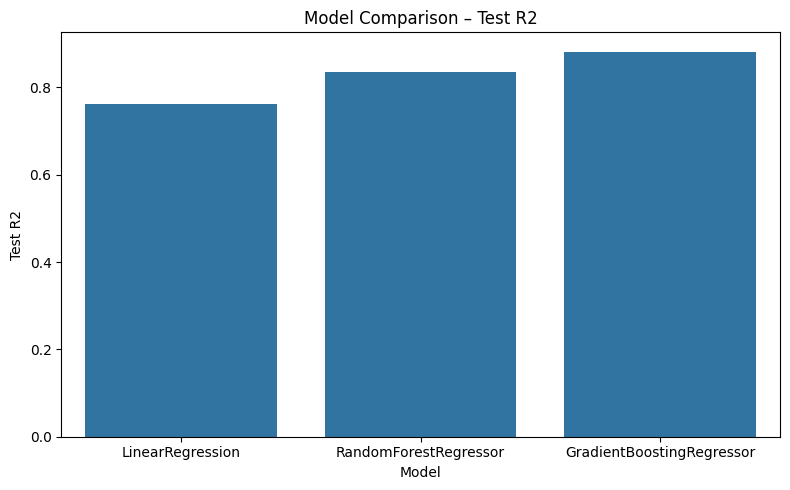

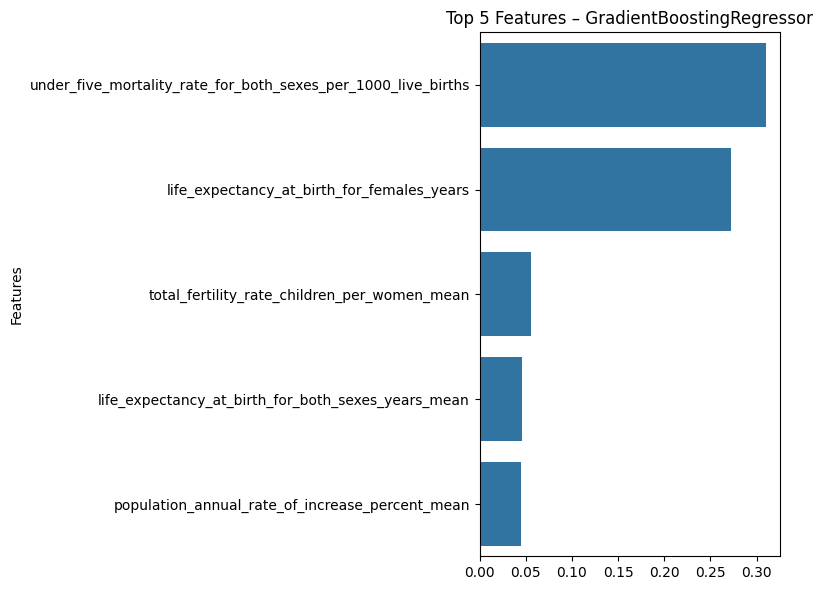

In [9]:
evaluator_h1.plot_comparison("Test R2")
evaluator_h1.plot_feature_importance("GradientBoostingRegressor")



## Evaluation H2: Does life expectancy predict population growth?” (Regression)



In [10]:


evaluator_h2 = ModelEvaluator()

comparison_h2 = evaluator_h2.evaluate_models(
    trainer_h2,
    ["LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor"],
    cv=5
)

comparison_h2

,Model,Train R2,Test R2,RMSE,MAE,CV Mean R2,CV Std
0,LinearRegression,0.849775,0.872334,0.293194,0.214015,0.717782,0.125428
1,RandomForestRegressor,0.940810,0.757528,0.404061,0.300265,0.674585,0.098239
2,GradientBoostingRegressor,0.982296,0.768434,0.394869,0.308613,0.676866,0.087575


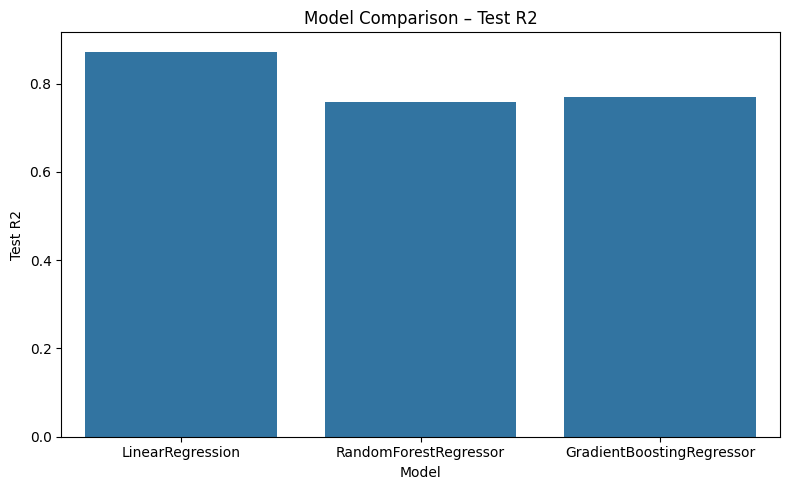

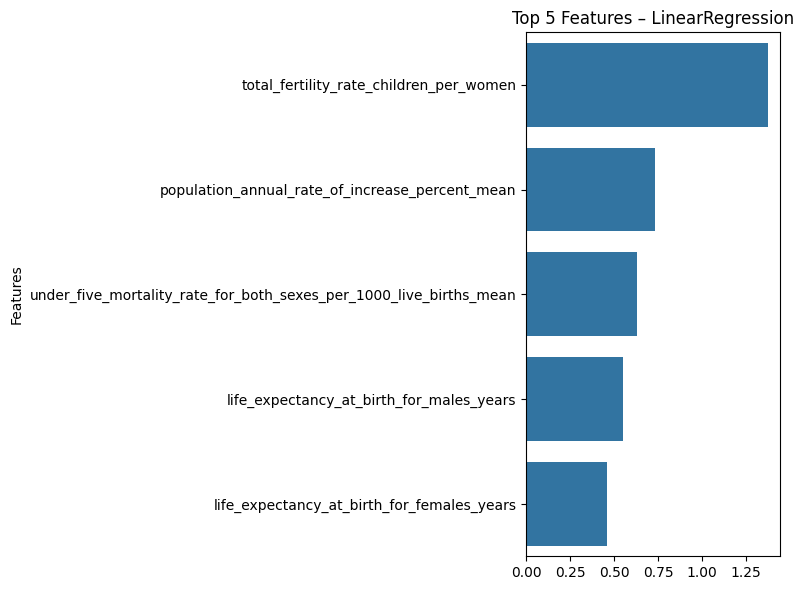

In [11]:
evaluator_h2.plot_comparison("Test R2")
evaluator_h2.plot_feature_importance("LinearRegression")


### Evaluation Does under-five mortality predict life expectancy?” (Regression)

In [12]:
evaluator_h3 = ModelEvaluator()

comparison_h3 = evaluator_h3.evaluate_models(
    trainer_h3,
    ["LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor"],
    cv=5
)

comparison_h3

,Model,Train R2,Test R2,RMSE,MAE,CV Mean R2,CV Std
0,LinearRegression,0.999871,0.999661,0.111374,0.077823,0.999822,0.000065
1,RandomForestRegressor,0.998318,0.997109,0.325265,0.242122,0.986470,0.013378
2,GradientBoostingRegressor,0.999905,0.997447,0.305644,0.228547,0.990561,0.008125


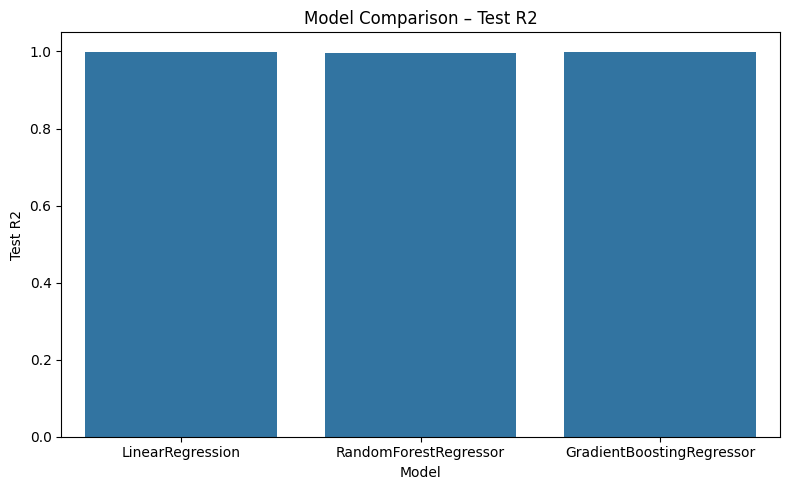

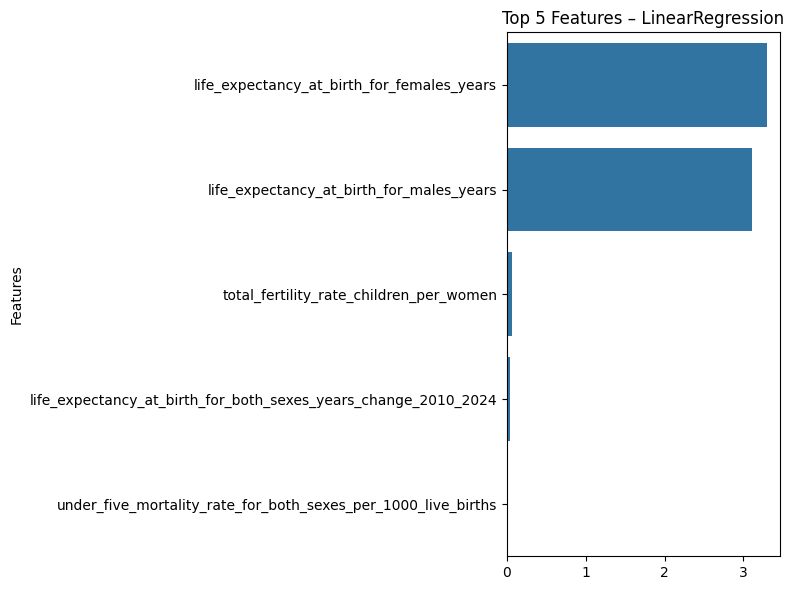

In [13]:
evaluator_h3.plot_comparison("Test R2")
evaluator_h3.plot_feature_importance("LinearRegression")
